In [1]:
from keras import backend as K
from tensorflow import keras
#import keras

import tensorflow.keras.applications

import cv2
from PIL import Image

from Utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
#from tensorflow.python.keras.layers import *
from keras.layers import Input, Dense, Flatten, Dropout
#from keras.applications.mobilenetv2 import MobileNetV2

import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape

import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import BatchNormalization

#from keras.models import Model
#from keras.layers import Input, Dense, Flatten, Dropout

In [2]:
#Variable Definition
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

In [3]:
#import data
#X and Y numpy arrays are created using the Prepocess.py file
X = np.load('data/signboard/npy/final/X.npy')
Y = np.load('data/signboard/npy/final/Y.npy')

In [4]:
print(X.shape , Y.shape)

(212, 512, 512, 3) (212, 16, 16, 1, 5)


In [5]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.8 , shuffle = True)
X = []
Y = []

In [21]:
#define model
# input : 512,512,3
# output : 16,16,1,5



def save_model(model):
    model_json = model.to_json()
    with open("pretrained_models/textline_detect_model32.json", "w") as json_file:
        json_file.write(model_json)

        
        
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
    

    
    
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    model = Model(inp,final)
    
    return model



In [22]:
#define utils

#optimizer
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#checkpoint
checkpoint = ModelCheckpoint('pretrained_models/text_detect32.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_freq=1)


In [23]:
#define loss function
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

In [24]:
#load and save model
input_size = (512, 512, 3)

model = yolo_model(input_size)

print(model.summary())

save_model(model)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_2_add (Add)              (None, 128, 128, 24  0           ['block_1_project_BN[0][0]',     
                                )                                 'block_2_project_BN[0][0]']     
                                                                                                  
 block_3_expand (Conv2D)        (None, 128, 128, 14  3456        ['block_2_add[0][0]']            
                                4)                                                                
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, 128, 128, 14  576        ['block_3_expand[0][0]']         
 ization)                       4)                                                                
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 128, 128, 14  0           ['block_3_expand_BN[0][0]']      
          

 block_6_depthwise (DepthwiseCo  (None, 32, 32, 192)  1728       ['block_6_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_6_depthwise_BN (BatchNor  (None, 32, 32, 192)  768        ['block_6_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_6_depthwise_relu (ReLU)  (None, 32, 32, 192)  0           ['block_6_depthwise_BN[0][0]']   
                                                                                                  
 block_6_project (Conv2D)       (None, 32, 32, 64)   12288       ['block_6_depthwise_relu[0][0]'] 
                                                                                                  
 block_6_p

                                                                                                  
 block_10_expand_BN (BatchNorma  (None, 32, 32, 384)  1536       ['block_10_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_10_expand_relu (ReLU)    (None, 32, 32, 384)  0           ['block_10_expand_BN[0][0]']     
                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 32, 32, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_10_depthwise_BN (BatchNo  (None, 32, 32, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalizati

                                                                                                  
 block_13_project_BN (BatchNorm  (None, 16, 16, 160)  640        ['block_13_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_expand (Conv2D)       (None, 16, 16, 960)  153600      ['block_13_project_BN[0][0]']    
                                                                                                  
 block_14_expand_BN (BatchNorma  (None, 16, 16, 960)  3840       ['block_14_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_14_expand_relu (ReLU)    (None, 16, 16, 960)  0           ['block_14_expand_BN[0][0]']     
          

 batch_normalization_4 (BatchNo  (None, 16, 16, 512)  2048       ['dropout_4[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_4[0][0]']  
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 128)  589952      ['leaky_re_lu_4[0][0]']          
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 128)  0           ['conv2d_7[0][0]']               
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 16, 16, 128)  512        ['dropout_5[0][0]']              
 rmalizati

In [16]:
model.load_weights('pretrained_models/textline_detect2.h5')

In [17]:
model.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

In [18]:
# epochs , batch_size
# 300, 10
hist = model.fit(X_train ,Y_train ,epochs= 180 ,batch_size = 4 , callbacks=[checkpoint] , validation_data=(X_val,Y_val))

Epoch 1/180


2022-06-22 20:20:16.352288: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-22 20:20:18.295570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 30.8804 - accuracy: 0.0636

2022-06-22 20:20:39.548684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 25s 461ms/step - loss: 30.8804 - accuracy: 0.0636 - val_loss: 34.0778 - val_accuracy: 0.0418
Epoch 2/180
43/43 [==============================] - 17s 397ms/step - loss: 28.0958 - accuracy: 0.0655 - val_loss: 33.4075 - val_accuracy: 0.0403
Epoch 3/180
 6/43 [===>..........................] - ETA: 13s - loss: 27.2490 - accuracy: 0.0649WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 410ms/step - loss: 26.4599 - accuracy: 0.0653 - val_loss: 32.5383 - val_accuracy: 0.0354
Epoch 4/180
43/43 [==============================] - 18s 406ms/step - loss: 24.3911 - accuracy: 0.0607 - val_loss: 32.4073 - val_accuracy: 0.0296
Epoch 5/180
20/43 [============>.................] - ETA: 8s - loss: 23.0142 - accuracy: 0.0600WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 406ms/step - loss: 23.5786 - accuracy: 0.0607 - val_loss: 32.0541 - val_accuracy: 0.0314
Epoch 6/180
43/43 [==============================] - 17s 394ms/step - loss: 22.2673 - accuracy: 0.0611 - val_loss: 32.0479 - val_accuracy: 0.0316
Epoch 7/180
34/43 [======================>.......] - ETA: 3s - loss: 21.3986 - accuracy: 0.0599WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 404ms/step - loss: 21.0941 - accuracy: 0.0611 - val_loss: 32.0676 - val_accuracy: 0.0342
Epoch 8/180
43/43 [==============================] - 18s 429ms/step - loss: 20.3443 - accuracy: 0.0625 - val_loss: 32.4532 - val_accuracy: 0.0360
Epoch 9/180
43/43 [==============================] - 18s 421ms/step - loss: 19.8350 - accuracy: 0.0620 - val_loss: 32.2964 - val_accuracy: 0.0353
Epoch 10/180
 5/43 [==>...........................] - ETA: 14s - loss: 19.6183 - accuracy: 0.0582WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 433ms/step - loss: 18.7453 - accuracy: 0.0599 - val_loss: 32.5952 - val_accuracy: 0.0357
Epoch 11/180
43/43 [==============================] - 19s 427ms/step - loss: 18.2481 - accuracy: 0.0601 - val_loss: 32.8087 - val_accuracy: 0.0360
Epoch 12/180
19/43 [============>.................] - ETA: 9s - loss: 17.8441 - accuracy: 0.0636WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 399ms/step - loss: 17.6633 - accuracy: 0.0600 - val_loss: 32.9835 - val_accuracy: 0.0340
Epoch 13/180
43/43 [==============================] - 17s 387ms/step - loss: 17.1518 - accuracy: 0.0549 - val_loss: 32.6512 - val_accuracy: 0.0297
Epoch 14/180
33/43 [======================>.......] - ETA: 3s - loss: 16.2003 - accuracy: 0.0518WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 406ms/step - loss: 16.5662 - accuracy: 0.0519 - val_loss: 32.3780 - val_accuracy: 0.0299
Epoch 15/180
43/43 [==============================] - 17s 395ms/step - loss: 16.1633 - accuracy: 0.0524 - val_loss: 32.7701 - val_accuracy: 0.0327
Epoch 16/180
43/43 [==============================] - 20s 474ms/step - loss: 15.6543 - accuracy: 0.0535 - val_loss: 32.8897 - val_accuracy: 0.0362
Epoch 17/180
 4/43 [=>............................] - ETA: 17s - loss: 12.9400 - accuracy: 0.0598WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 20s 464ms/step - loss: 15.7968 - accuracy: 0.0542 - val_loss: 32.0456 - val_accuracy: 0.0337
Epoch 18/180
43/43 [==============================] - 19s 432ms/step - loss: 15.5247 - accuracy: 0.0520 - val_loss: 32.9154 - val_accuracy: 0.0267
Epoch 19/180
18/43 [===========>..................] - ETA: 9s - loss: 15.9400 - accuracy: 0.0457WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 416ms/step - loss: 14.9973 - accuracy: 0.0452 - val_loss: 31.6980 - val_accuracy: 0.0302
Epoch 20/180
43/43 [==============================] - 19s 444ms/step - loss: 14.2848 - accuracy: 0.0446 - val_loss: 31.8833 - val_accuracy: 0.0330
Epoch 21/180
32/43 [=====================>........] - ETA: 4s - loss: 14.2612 - accuracy: 0.0454WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 419ms/step - loss: 13.8568 - accuracy: 0.0455 - val_loss: 33.1809 - val_accuracy: 0.0357
Epoch 22/180
43/43 [==============================] - 18s 418ms/step - loss: 13.7821 - accuracy: 0.0460 - val_loss: 33.1256 - val_accuracy: 0.0367
Epoch 23/180
43/43 [==============================] - 19s 430ms/step - loss: 13.2470 - accuracy: 0.0463 - val_loss: 32.4274 - val_accuracy: 0.0370
Epoch 24/180
 3/43 [=>............................] - ETA: 14s - loss: 16.2418 - accuracy: 0.0449WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 398ms/step - loss: 13.4080 - accuracy: 0.0481 - val_loss: 32.1248 - val_accuracy: 0.0383
Epoch 25/180
43/43 [==============================] - 19s 432ms/step - loss: 13.0300 - accuracy: 0.0479 - val_loss: 32.3527 - val_accuracy: 0.0388
Epoch 26/180
17/43 [==========>...................] - ETA: 10s - loss: 12.2338 - accuracy: 0.0489WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 436ms/step - loss: 13.0757 - accuracy: 0.0481 - val_loss: 32.8276 - val_accuracy: 0.0391
Epoch 27/180
43/43 [==============================] - 19s 433ms/step - loss: 12.7544 - accuracy: 0.0475 - val_loss: 32.9831 - val_accuracy: 0.0408
Epoch 28/180
31/43 [====================>.........] - ETA: 6s - loss: 12.5694 - accuracy: 0.0474WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 23s 529ms/step - loss: 12.7933 - accuracy: 0.0470 - val_loss: 32.3607 - val_accuracy: 0.0410
Epoch 29/180
43/43 [==============================] - 17s 400ms/step - loss: 12.6223 - accuracy: 0.0470 - val_loss: 32.1133 - val_accuracy: 0.0415
Epoch 30/180
43/43 [==============================] - 18s 421ms/step - loss: 12.6250 - accuracy: 0.0488 - val_loss: 32.1689 - val_accuracy: 0.0413
Epoch 31/180
 2/43 [>.............................] - ETA: 14s - loss: 11.2387 - accuracy: 0.0415WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 424ms/step - loss: 12.5546 - accuracy: 0.0463 - val_loss: 32.5745 - val_accuracy: 0.0413
Epoch 32/180
43/43 [==============================] - 19s 426ms/step - loss: 12.4965 - accuracy: 0.0478 - val_loss: 32.2923 - val_accuracy: 0.0399
Epoch 33/180
16/43 [==========>...................] - ETA: 10s - loss: 12.0739 - accuracy: 0.0475WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 431ms/step - loss: 12.5319 - accuracy: 0.0485 - val_loss: 31.9425 - val_accuracy: 0.0410
Epoch 34/180
43/43 [==============================] - 17s 396ms/step - loss: 12.5269 - accuracy: 0.0496 - val_loss: 32.1938 - val_accuracy: 0.0433
Epoch 35/180
30/43 [===================>..........] - ETA: 5s - loss: 12.5471 - accuracy: 0.0507WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 422ms/step - loss: 12.4555 - accuracy: 0.0503 - val_loss: 31.8568 - val_accuracy: 0.0429
Epoch 36/180
43/43 [==============================] - 18s 423ms/step - loss: 12.4022 - accuracy: 0.0500 - val_loss: 32.1320 - val_accuracy: 0.0434
Epoch 37/180
43/43 [==============================] - 18s 411ms/step - loss: 12.9965 - accuracy: 0.0507 - val_loss: 32.2945 - val_accuracy: 0.0412
Epoch 38/180
 1/43 [..............................] - ETA: 19s - loss: 13.3313 - accuracy: 0.0498WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 432ms/step - loss: 12.3279 - accuracy: 0.0498 - val_loss: 32.0857 - val_accuracy: 0.0404
Epoch 39/180
43/43 [==============================] - 18s 414ms/step - loss: 12.4110 - accuracy: 0.0466 - val_loss: 31.3796 - val_accuracy: 0.0376
Epoch 40/180
15/43 [=========>....................] - ETA: 11s - loss: 12.3562 - accuracy: 0.0484WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 20s 449ms/step - loss: 12.0971 - accuracy: 0.0471 - val_loss: 31.4873 - val_accuracy: 0.0392
Epoch 41/180
43/43 [==============================] - 19s 428ms/step - loss: 12.0202 - accuracy: 0.0471 - val_loss: 31.2343 - val_accuracy: 0.0384
Epoch 42/180
29/43 [===================>..........] - ETA: 5s - loss: 12.2682 - accuracy: 0.0470WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 436ms/step - loss: 12.1093 - accuracy: 0.0455 - val_loss: 32.2368 - val_accuracy: 0.0347
Epoch 43/180
43/43 [==============================] - 19s 443ms/step - loss: 11.9589 - accuracy: 0.0398 - val_loss: 32.0131 - val_accuracy: 0.0295
Epoch 44/180
43/43 [==============================] - 17s 402ms/step - loss: 11.7879 - accuracy: 0.0425 - val_loss: 31.6059 - val_accuracy: 0.0392
Epoch 45/180


43/43 [==============================] - 17s 398ms/step - loss: 11.6444 - accuracy: 0.0441 - val_loss: 31.4935 - val_accuracy: 0.0387
Epoch 46/180
43/43 [==============================] - 18s 424ms/step - loss: 11.4937 - accuracy: 0.0441 - val_loss: 31.6281 - val_accuracy: 0.0394
Epoch 47/180
14/43 [========>.....................] - ETA: 12s - loss: 10.9107 - accuracy: 0.0469WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 20s 457ms/step - loss: 11.4880 - accuracy: 0.0462 - val_loss: 31.3775 - val_accuracy: 0.0403
Epoch 48/180
43/43 [==============================] - 34s 784ms/step - loss: 11.4430 - accuracy: 0.0475 - val_loss: 31.3929 - val_accuracy: 0.0422
Epoch 49/180
28/43 [==================>...........] - ETA: 6s - loss: 11.4556 - accuracy: 0.0464WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 419ms/step - loss: 11.4876 - accuracy: 0.0467 - val_loss: 31.4375 - val_accuracy: 0.0413
Epoch 50/180
43/43 [==============================] - 17s 399ms/step - loss: 11.3903 - accuracy: 0.0477 - val_loss: 31.4922 - val_accuracy: 0.0411
Epoch 51/180
42/43 [============================>.] - ETA: 0s - loss: 11.4144 - accuracy: 0.0471WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 412ms/step - loss: 11.3857 - accuracy: 0.0471 - val_loss: 31.4211 - val_accuracy: 0.0410
Epoch 52/180
43/43 [==============================] - 18s 420ms/step - loss: 11.3376 - accuracy: 0.0471 - val_loss: 31.8625 - val_accuracy: 0.0412
Epoch 53/180
 6/43 [===>..........................] - ETA: 14s - loss: 12.3005 - accuracy: 0.0457WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 440ms/step - loss: 11.3482 - accuracy: 0.0473 - val_loss: 31.6536 - val_accuracy: 0.0402
Epoch 54/180
43/43 [==============================] - 18s 409ms/step - loss: 11.1444 - accuracy: 0.0478 - val_loss: 31.6371 - val_accuracy: 0.0411
Epoch 55/180
20/43 [============>.................] - ETA: 8s - loss: 11.8029 - accuracy: 0.0479WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 440ms/step - loss: 11.2555 - accuracy: 0.0478 - val_loss: 31.5647 - val_accuracy: 0.0415
Epoch 56/180
43/43 [==============================] - 20s 461ms/step - loss: 11.1837 - accuracy: 0.0484 - val_loss: 31.5484 - val_accuracy: 0.0432
Epoch 57/180
34/43 [======================>.......] - ETA: 4s - loss: 10.9522 - accuracy: 0.0484WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 22s 509ms/step - loss: 11.1152 - accuracy: 0.0490 - val_loss: 31.7223 - val_accuracy: 0.0424
Epoch 58/180
43/43 [==============================] - 21s 485ms/step - loss: 10.9478 - accuracy: 0.0479 - val_loss: 31.5099 - val_accuracy: 0.0422
Epoch 59/180
43/43 [==============================] - 23s 484ms/step - loss: 10.9607 - accuracy: 0.0473 - val_loss: 31.3210 - val_accuracy: 0.0419
Epoch 60/180
 5/43 [==>...........................] - ETA: 14s - loss: 9.3480 - accuracy: 0.0471WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 421ms/step - loss: 10.8370 - accuracy: 0.0485 - val_loss: 31.4671 - val_accuracy: 0.0416
Epoch 61/180
43/43 [==============================] - 18s 412ms/step - loss: 10.9954 - accuracy: 0.0460 - val_loss: 31.5927 - val_accuracy: 0.0421
Epoch 62/180
19/43 [============>.................] - ETA: 9s - loss: 11.6677 - accuracy: 0.0462WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 424ms/step - loss: 10.8380 - accuracy: 0.0470 - val_loss: 31.2698 - val_accuracy: 0.0428
Epoch 63/180
43/43 [==============================] - 18s 415ms/step - loss: 10.7782 - accuracy: 0.0467 - val_loss: 31.3349 - val_accuracy: 0.0433
Epoch 64/180
33/43 [======================>.......] - ETA: 3s - loss: 11.0332 - accuracy: 0.0468WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 414ms/step - loss: 10.8434 - accuracy: 0.0469 - val_loss: 31.4981 - val_accuracy: 0.0427
Epoch 65/180
43/43 [==============================] - 17s 404ms/step - loss: 10.7804 - accuracy: 0.0457 - val_loss: 31.2400 - val_accuracy: 0.0430
Epoch 66/180
43/43 [==============================] - 21s 480ms/step - loss: 10.7282 - accuracy: 0.0475 - val_loss: 31.2809 - val_accuracy: 0.0428
Epoch 67/180
 4/43 [=>............................] - ETA: 16s - loss: 7.9827 - accuracy: 0.0437WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 405ms/step - loss: 10.8157 - accuracy: 0.0472 - val_loss: 31.1596 - val_accuracy: 0.0425
Epoch 68/180
43/43 [==============================] - 18s 408ms/step - loss: 10.7847 - accuracy: 0.0474 - val_loss: 31.0037 - val_accuracy: 0.0440
Epoch 69/180
18/43 [===========>..................] - ETA: 9s - loss: 10.7104 - accuracy: 0.0484WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 384ms/step - loss: 10.7314 - accuracy: 0.0484 - val_loss: 31.3311 - val_accuracy: 0.0445
Epoch 70/180
43/43 [==============================] - 17s 394ms/step - loss: 10.6333 - accuracy: 0.0485 - val_loss: 31.4323 - val_accuracy: 0.0454
Epoch 71/180
32/43 [=====================>........] - ETA: 4s - loss: 11.2700 - accuracy: 0.0485WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 408ms/step - loss: 10.7855 - accuracy: 0.0483 - val_loss: 31.6365 - val_accuracy: 0.0461
Epoch 72/180
43/43 [==============================] - 18s 428ms/step - loss: 10.7436 - accuracy: 0.0497 - val_loss: 31.8491 - val_accuracy: 0.0458
Epoch 73/180
43/43 [==============================] - 20s 462ms/step - loss: 10.7133 - accuracy: 0.0456 - val_loss: 31.6993 - val_accuracy: 0.0450
Epoch 74/180
 3/43 [=>............................] - ETA: 14s - loss: 9.8808 - accuracy: 0.0417WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 401ms/step - loss: 10.6506 - accuracy: 0.0452 - val_loss: 31.6611 - val_accuracy: 0.0463
Epoch 75/180
43/43 [==============================] - 17s 400ms/step - loss: 10.6049 - accuracy: 0.0469 - val_loss: 31.5554 - val_accuracy: 0.0484
Epoch 76/180
17/43 [==========>...................] - ETA: 9s - loss: 9.9083 - accuracy: 0.0456WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 394ms/step - loss: 10.5793 - accuracy: 0.0459 - val_loss: 31.5837 - val_accuracy: 0.0477
Epoch 77/180
43/43 [==============================] - 17s 386ms/step - loss: 10.5387 - accuracy: 0.0472 - val_loss: 32.0208 - val_accuracy: 0.0490
Epoch 78/180
31/43 [====================>.........] - ETA: 4s - loss: 10.5652 - accuracy: 0.0471WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 389ms/step - loss: 10.5166 - accuracy: 0.0475 - val_loss: 31.5825 - val_accuracy: 0.0497
Epoch 79/180
43/43 [==============================] - 16s 384ms/step - loss: 10.4830 - accuracy: 0.0474 - val_loss: 31.9069 - val_accuracy: 0.0491
Epoch 80/180
43/43 [==============================] - 17s 386ms/step - loss: 10.4362 - accuracy: 0.0482 - val_loss: 31.9384 - val_accuracy: 0.0485
Epoch 81/180
 2/43 [>.............................] - ETA: 14s - loss: 12.6478 - accuracy: 0.0415WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 384ms/step - loss: 10.4594 - accuracy: 0.0475 - val_loss: 31.7812 - val_accuracy: 0.0488
Epoch 82/180
43/43 [==============================] - 16s 383ms/step - loss: 10.4595 - accuracy: 0.0467 - val_loss: 31.8370 - val_accuracy: 0.0495
Epoch 83/180
16/43 [==========>...................] - ETA: 9s - loss: 10.7155 - accuracy: 0.0474 WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 380ms/step - loss: 10.4323 - accuracy: 0.0477 - val_loss: 31.6106 - val_accuracy: 0.0497
Epoch 84/180
43/43 [==============================] - 16s 380ms/step - loss: 10.4269 - accuracy: 0.0469 - val_loss: 31.8245 - val_accuracy: 0.0490
Epoch 85/180
30/43 [===================>..........] - ETA: 4s - loss: 10.4423 - accuracy: 0.0480WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 383ms/step - loss: 10.4552 - accuracy: 0.0476 - val_loss: 32.2140 - val_accuracy: 0.0489
Epoch 86/180
43/43 [==============================] - 16s 378ms/step - loss: 10.4400 - accuracy: 0.0467 - val_loss: 32.1453 - val_accuracy: 0.0488
Epoch 87/180
43/43 [==============================] - 16s 379ms/step - loss: 10.3454 - accuracy: 0.0471 - val_loss: 32.0149 - val_accuracy: 0.0492
Epoch 88/180
 1/43 [..............................] - ETA: 16s - loss: 17.8441 - accuracy: 0.0469WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 384ms/step - loss: 10.3905 - accuracy: 0.0475 - val_loss: 31.9169 - val_accuracy: 0.0491
Epoch 89/180
43/43 [==============================] - 17s 385ms/step - loss: 10.4139 - accuracy: 0.0461 - val_loss: 31.7632 - val_accuracy: 0.0485
Epoch 90/180
15/43 [=========>....................] - ETA: 10s - loss: 10.0153 - accuracy: 0.0487WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 431ms/step - loss: 10.4230 - accuracy: 0.0473 - val_loss: 31.7766 - val_accuracy: 0.0487
Epoch 91/180
43/43 [==============================] - 20s 469ms/step - loss: 10.3646 - accuracy: 0.0467 - val_loss: 32.0325 - val_accuracy: 0.0490
Epoch 92/180
29/43 [===================>..........] - ETA: 5s - loss: 10.7220 - accuracy: 0.0493WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 429ms/step - loss: 10.4692 - accuracy: 0.0485 - val_loss: 31.6235 - val_accuracy: 0.0482
Epoch 93/180
43/43 [==============================] - 17s 402ms/step - loss: 10.3784 - accuracy: 0.0476 - val_loss: 31.7928 - val_accuracy: 0.0484
Epoch 94/180
43/43 [==============================] - 17s 392ms/step - loss: 10.3207 - accuracy: 0.0474 - val_loss: 31.5987 - val_accuracy: 0.0481
Epoch 95/180


43/43 [==============================] - 17s 401ms/step - loss: 10.3293 - accuracy: 0.0472 - val_loss: 31.5148 - val_accuracy: 0.0482
Epoch 96/180
43/43 [==============================] - 17s 402ms/step - loss: 10.2719 - accuracy: 0.0469 - val_loss: 31.6216 - val_accuracy: 0.0476
Epoch 97/180
14/43 [========>.....................] - ETA: 10s - loss: 10.2697 - accuracy: 0.0487WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 387ms/step - loss: 10.2813 - accuracy: 0.0484 - val_loss: 31.8552 - val_accuracy: 0.0491
Epoch 98/180
43/43 [==============================] - 17s 395ms/step - loss: 10.2725 - accuracy: 0.0488 - val_loss: 31.6457 - val_accuracy: 0.0495
Epoch 99/180
28/43 [==================>...........] - ETA: 5s - loss: 10.0014 - accuracy: 0.0482WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 392ms/step - loss: 10.3189 - accuracy: 0.0483 - val_loss: 31.4711 - val_accuracy: 0.0487
Epoch 100/180
43/43 [==============================] - 17s 390ms/step - loss: 10.3127 - accuracy: 0.0476 - val_loss: 31.6801 - val_accuracy: 0.0496
Epoch 101/180
42/43 [============================>.] - ETA: 0s - loss: 10.3414 - accuracy: 0.0491WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 399ms/step - loss: 10.2986 - accuracy: 0.0491 - val_loss: 31.8249 - val_accuracy: 0.0507
Epoch 102/180
43/43 [==============================] - 19s 450ms/step - loss: 10.2398 - accuracy: 0.0483 - val_loss: 32.1464 - val_accuracy: 0.0522
Epoch 103/180
 6/43 [===>..........................] - ETA: 13s - loss: 10.1984 - accuracy: 0.0526WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 400ms/step - loss: 10.2991 - accuracy: 0.0493 - val_loss: 32.1993 - val_accuracy: 0.0514
Epoch 104/180
43/43 [==============================] - 17s 406ms/step - loss: 10.2641 - accuracy: 0.0492 - val_loss: 31.8563 - val_accuracy: 0.0508
Epoch 105/180
20/43 [============>.................] - ETA: 8s - loss: 9.3512 - accuracy: 0.0485WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 415ms/step - loss: 10.2583 - accuracy: 0.0490 - val_loss: 31.8479 - val_accuracy: 0.0504
Epoch 106/180
43/43 [==============================] - 18s 405ms/step - loss: 10.2861 - accuracy: 0.0488 - val_loss: 31.5800 - val_accuracy: 0.0535
Epoch 107/180
34/43 [======================>.......] - ETA: 3s - loss: 10.0196 - accuracy: 0.0502WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 407ms/step - loss: 10.3578 - accuracy: 0.0501 - val_loss: 31.7138 - val_accuracy: 0.0542
Epoch 108/180
43/43 [==============================] - 17s 399ms/step - loss: 10.4031 - accuracy: 0.0502 - val_loss: 31.7575 - val_accuracy: 0.0527
Epoch 109/180
43/43 [==============================] - 20s 462ms/step - loss: 10.4396 - accuracy: 0.0440 - val_loss: 31.4845 - val_accuracy: 0.0460
Epoch 110/180
 5/43 [==>...........................] - ETA: 15s - loss: 10.0944 - accuracy: 0.0352WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 423ms/step - loss: 10.5369 - accuracy: 0.0369 - val_loss: 31.2737 - val_accuracy: 0.0449
Epoch 111/180
43/43 [==============================] - 18s 414ms/step - loss: 10.3695 - accuracy: 0.0379 - val_loss: 31.3693 - val_accuracy: 0.0465
Epoch 112/180
19/43 [============>.................] - ETA: 10s - loss: 10.5997 - accuracy: 0.0392WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 428ms/step - loss: 10.3552 - accuracy: 0.0398 - val_loss: 31.0340 - val_accuracy: 0.0472
Epoch 113/180
43/43 [==============================] - 18s 415ms/step - loss: 10.3215 - accuracy: 0.0415 - val_loss: 31.7145 - val_accuracy: 0.0443
Epoch 114/180
33/43 [======================>.......] - ETA: 3s - loss: 10.1268 - accuracy: 0.0412WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 403ms/step - loss: 10.3082 - accuracy: 0.0412 - val_loss: 31.1619 - val_accuracy: 0.0473
Epoch 115/180
43/43 [==============================] - 18s 428ms/step - loss: 10.2589 - accuracy: 0.0417 - val_loss: 31.0354 - val_accuracy: 0.0471
Epoch 116/180
43/43 [==============================] - 18s 422ms/step - loss: 10.1843 - accuracy: 0.0420 - val_loss: 31.3021 - val_accuracy: 0.0465
Epoch 117/180
 4/43 [=>............................] - ETA: 15s - loss: 10.9095 - accuracy: 0.0381WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 412ms/step - loss: 10.1693 - accuracy: 0.0417 - val_loss: 31.5406 - val_accuracy: 0.0464
Epoch 118/180
43/43 [==============================] - 18s 416ms/step - loss: 10.1214 - accuracy: 0.0423 - val_loss: 30.8890 - val_accuracy: 0.0464
Epoch 119/180
18/43 [===========>..................] - ETA: 9s - loss: 9.9359 - accuracy: 0.0429 WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 411ms/step - loss: 10.0646 - accuracy: 0.0435 - val_loss: 30.7567 - val_accuracy: 0.0456
Epoch 120/180
43/43 [==============================] - 18s 416ms/step - loss: 10.0541 - accuracy: 0.0421 - val_loss: 30.6993 - val_accuracy: 0.0449
Epoch 121/180
32/43 [=====================>........] - ETA: 4s - loss: 9.6948 - accuracy: 0.0423WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 400ms/step - loss: 10.0031 - accuracy: 0.0423 - val_loss: 30.5657 - val_accuracy: 0.0457
Epoch 122/180
43/43 [==============================] - 19s 443ms/step - loss: 9.9746 - accuracy: 0.0424 - val_loss: 31.1509 - val_accuracy: 0.0476
Epoch 123/180
43/43 [==============================] - 18s 408ms/step - loss: 9.9806 - accuracy: 0.0446 - val_loss: 31.2289 - val_accuracy: 0.0470
Epoch 124/180
 3/43 [=>............................] - ETA: 14s - loss: 12.8459 - accuracy: 0.0479WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 397ms/step - loss: 9.9955 - accuracy: 0.0454 - val_loss: 30.9286 - val_accuracy: 0.0474
Epoch 125/180
43/43 [==============================] - 17s 404ms/step - loss: 9.8885 - accuracy: 0.0446 - val_loss: 30.7270 - val_accuracy: 0.0463
Epoch 126/180
17/43 [==========>...................] - ETA: 9s - loss: 10.4390 - accuracy: 0.0442 WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 18s 411ms/step - loss: 9.9545 - accuracy: 0.0447 - val_loss: 30.9002 - val_accuracy: 0.0476
Epoch 127/180
43/43 [==============================] - 18s 425ms/step - loss: 9.9309 - accuracy: 0.0457 - val_loss: 30.8293 - val_accuracy: 0.0472
Epoch 128/180
31/43 [====================>.........] - ETA: 5s - loss: 10.4584 - accuracy: 0.0444WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 24s 550ms/step - loss: 9.9168 - accuracy: 0.0454 - val_loss: 31.0946 - val_accuracy: 0.0463
Epoch 129/180
43/43 [==============================] - 20s 435ms/step - loss: 9.9961 - accuracy: 0.0455 - val_loss: 30.8253 - val_accuracy: 0.0464
Epoch 130/180
43/43 [==============================] - 20s 459ms/step - loss: 9.9392 - accuracy: 0.0456 - val_loss: 31.0948 - val_accuracy: 0.0474
Epoch 131/180
 2/43 [>.............................] - ETA: 16s - loss: 8.4785 - accuracy: 0.0483WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 19s 446ms/step - loss: 9.9507 - accuracy: 0.0469 - val_loss: 31.0020 - val_accuracy: 0.0479
Epoch 132/180
43/43 [==============================] - 17s 397ms/step - loss: 9.9693 - accuracy: 0.0467 - val_loss: 31.1494 - val_accuracy: 0.0486
Epoch 133/180
16/43 [==========>...................] - ETA: 9s - loss: 10.4216 - accuracy: 0.0471 WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 382ms/step - loss: 9.9840 - accuracy: 0.0473 - val_loss: 30.9510 - val_accuracy: 0.0481
Epoch 134/180
43/43 [==============================] - 17s 385ms/step - loss: 9.9189 - accuracy: 0.0473 - val_loss: 31.0733 - val_accuracy: 0.0506
Epoch 135/180
30/43 [===================>..........] - ETA: 4s - loss: 10.0620 - accuracy: 0.0485WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 384ms/step - loss: 9.9094 - accuracy: 0.0480 - val_loss: 31.3159 - val_accuracy: 0.0498
Epoch 136/180
43/43 [==============================] - 16s 379ms/step - loss: 9.9520 - accuracy: 0.0472 - val_loss: 31.8852 - val_accuracy: 0.0487
Epoch 137/180
43/43 [==============================] - 17s 391ms/step - loss: 9.9170 - accuracy: 0.0474 - val_loss: 31.4973 - val_accuracy: 0.0505
Epoch 138/180
 1/43 [..............................] - ETA: 15s - loss: 9.2377 - accuracy: 0.0449WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 381ms/step - loss: 9.8974 - accuracy: 0.0426 - val_loss: 30.7448 - val_accuracy: 0.0368
Epoch 139/180
43/43 [==============================] - 16s 379ms/step - loss: 9.8624 - accuracy: 0.0406 - val_loss: 31.2351 - val_accuracy: 0.0359
Epoch 140/180
15/43 [=========>....................] - ETA: 10s - loss: 9.6496 - accuracy: 0.0420WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 392ms/step - loss: 9.8463 - accuracy: 0.0406 - val_loss: 31.0945 - val_accuracy: 0.0354
Epoch 141/180
43/43 [==============================] - 17s 382ms/step - loss: 9.8327 - accuracy: 0.0409 - val_loss: 31.1902 - val_accuracy: 0.0349
Epoch 142/180
29/43 [===================>..........] - ETA: 5s - loss: 9.7256 - accuracy: 0.0410WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 381ms/step - loss: 9.7915 - accuracy: 0.0408 - val_loss: 31.1887 - val_accuracy: 0.0352
Epoch 143/180
43/43 [==============================] - 17s 387ms/step - loss: 9.8405 - accuracy: 0.0414 - val_loss: 31.2221 - val_accuracy: 0.0354
Epoch 144/180
43/43 [==============================] - 17s 389ms/step - loss: 9.7520 - accuracy: 0.0415 - val_loss: 31.2136 - val_accuracy: 0.0350
Epoch 145/180


43/43 [==============================] - 17s 384ms/step - loss: 9.7403 - accuracy: 0.0414 - val_loss: 31.0127 - val_accuracy: 0.0352
Epoch 146/180
43/43 [==============================] - 16s 383ms/step - loss: 9.7225 - accuracy: 0.0422 - val_loss: 31.2280 - val_accuracy: 0.0362
Epoch 147/180
14/43 [========>.....................] - ETA: 10s - loss: 10.0700 - accuracy: 0.0436WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 383ms/step - loss: 9.7132 - accuracy: 0.0415 - val_loss: 31.1851 - val_accuracy: 0.0315
Epoch 148/180
43/43 [==============================] - 16s 380ms/step - loss: 10.2631 - accuracy: 0.0382 - val_loss: 31.4362 - val_accuracy: 0.0392
Epoch 149/180
28/43 [==================>...........] - ETA: 5s - loss: 9.8617 - accuracy: 0.0427WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 381ms/step - loss: 9.6985 - accuracy: 0.0414 - val_loss: 31.2983 - val_accuracy: 0.0372
Epoch 150/180
43/43 [==============================] - 17s 387ms/step - loss: 9.8236 - accuracy: 0.0464 - val_loss: 31.4833 - val_accuracy: 0.0431
Epoch 151/180
42/43 [============================>.] - ETA: 0s - loss: 9.7595 - accuracy: 0.0469WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 385ms/step - loss: 9.7178 - accuracy: 0.0469 - val_loss: 31.3116 - val_accuracy: 0.0410
Epoch 152/180
43/43 [==============================] - 17s 385ms/step - loss: 9.8529 - accuracy: 0.0466 - val_loss: 31.3593 - val_accuracy: 0.0412
Epoch 153/180
 6/43 [===>..........................] - ETA: 13s - loss: 8.6991 - accuracy: 0.0436WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 384ms/step - loss: 9.7503 - accuracy: 0.0453 - val_loss: 31.5590 - val_accuracy: 0.0415
Epoch 154/180
43/43 [==============================] - 17s 388ms/step - loss: 9.7670 - accuracy: 0.0445 - val_loss: 31.4850 - val_accuracy: 0.0411
Epoch 155/180
20/43 [============>.................] - ETA: 8s - loss: 10.2077 - accuracy: 0.0440WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 380ms/step - loss: 9.7001 - accuracy: 0.0441 - val_loss: 31.3526 - val_accuracy: 0.0412
Epoch 156/180
43/43 [==============================] - 17s 386ms/step - loss: 9.7189 - accuracy: 0.0449 - val_loss: 31.1646 - val_accuracy: 0.0395
Epoch 157/180
34/43 [======================>.......] - ETA: 3s - loss: 9.5116 - accuracy: 0.0441WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 381ms/step - loss: 9.8148 - accuracy: 0.0444 - val_loss: 31.1238 - val_accuracy: 0.0362
Epoch 158/180
43/43 [==============================] - 16s 382ms/step - loss: 9.6484 - accuracy: 0.0435 - val_loss: 31.3517 - val_accuracy: 0.0373
Epoch 159/180
43/43 [==============================] - 17s 384ms/step - loss: 9.6875 - accuracy: 0.0439 - val_loss: 31.4137 - val_accuracy: 0.0379
Epoch 160/180
 5/43 [==>...........................] - ETA: 13s - loss: 8.7584 - accuracy: 0.0422WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 382ms/step - loss: 9.6906 - accuracy: 0.0440 - val_loss: 31.2327 - val_accuracy: 0.0382
Epoch 161/180
43/43 [==============================] - 16s 381ms/step - loss: 9.6625 - accuracy: 0.0443 - val_loss: 31.3026 - val_accuracy: 0.0392
Epoch 162/180
19/43 [============>.................] - ETA: 8s - loss: 9.2501 - accuracy: 0.0449WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 381ms/step - loss: 9.7015 - accuracy: 0.0449 - val_loss: 31.4018 - val_accuracy: 0.0387
Epoch 163/180
43/43 [==============================] - 16s 379ms/step - loss: 9.6486 - accuracy: 0.0441 - val_loss: 31.0220 - val_accuracy: 0.0384
Epoch 164/180
33/43 [======================>.......] - ETA: 3s - loss: 9.6792 - accuracy: 0.0445WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 381ms/step - loss: 9.6351 - accuracy: 0.0442 - val_loss: 31.3229 - val_accuracy: 0.0392
Epoch 165/180
43/43 [==============================] - 17s 386ms/step - loss: 9.6957 - accuracy: 0.0436 - val_loss: 30.8875 - val_accuracy: 0.0383
Epoch 166/180
43/43 [==============================] - 17s 385ms/step - loss: 9.6744 - accuracy: 0.0446 - val_loss: 31.0007 - val_accuracy: 0.0390
Epoch 167/180
 4/43 [=>............................] - ETA: 13s - loss: 9.9297 - accuracy: 0.0454WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 380ms/step - loss: 9.6169 - accuracy: 0.0447 - val_loss: 31.0296 - val_accuracy: 0.0370
Epoch 168/180
43/43 [==============================] - 16s 381ms/step - loss: 9.9083 - accuracy: 0.0395 - val_loss: 31.3855 - val_accuracy: 0.0392
Epoch 169/180
18/43 [===========>..................] - ETA: 8s - loss: 9.6831 - accuracy: 0.0457WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 383ms/step - loss: 9.6761 - accuracy: 0.0466 - val_loss: 31.1295 - val_accuracy: 0.0412
Epoch 170/180
43/43 [==============================] - 16s 381ms/step - loss: 9.6198 - accuracy: 0.0475 - val_loss: 31.2821 - val_accuracy: 0.0410
Epoch 171/180
32/43 [=====================>........] - ETA: 3s - loss: 9.6847 - accuracy: 0.0471WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 383ms/step - loss: 9.6362 - accuracy: 0.0470 - val_loss: 31.0514 - val_accuracy: 0.0403
Epoch 172/180
43/43 [==============================] - 16s 384ms/step - loss: 9.6342 - accuracy: 0.0470 - val_loss: 31.3219 - val_accuracy: 0.0402
Epoch 173/180
43/43 [==============================] - 16s 379ms/step - loss: 9.6376 - accuracy: 0.0465 - val_loss: 31.4100 - val_accuracy: 0.0408
Epoch 174/180
 3/43 [=>............................] - ETA: 14s - loss: 7.4987 - accuracy: 0.0482WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 382ms/step - loss: 9.6298 - accuracy: 0.0464 - val_loss: 31.0958 - val_accuracy: 0.0398
Epoch 175/180
43/43 [==============================] - 16s 381ms/step - loss: 9.6578 - accuracy: 0.0462 - val_loss: 31.1603 - val_accuracy: 0.0399
Epoch 176/180
17/43 [==========>...................] - ETA: 9s - loss: 10.3950 - accuracy: 0.0468 WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 17s 387ms/step - loss: 9.6543 - accuracy: 0.0468 - val_loss: 31.6004 - val_accuracy: 0.0399
Epoch 177/180
43/43 [==============================] - 16s 383ms/step - loss: 9.6858 - accuracy: 0.0474 - val_loss: 31.9733 - val_accuracy: 0.0527
Epoch 178/180
31/43 [====================>.........] - ETA: 4s - loss: 9.9783 - accuracy: 0.0583WARNING:tensorflow:Can save best model only with val_loss available, skipping.


43/43 [==============================] - 16s 384ms/step - loss: 9.7268 - accuracy: 0.0592 - val_loss: 31.6482 - val_accuracy: 0.0494
Epoch 179/180
43/43 [==============================] - 17s 385ms/step - loss: 9.7501 - accuracy: 0.0557 - val_loss: 31.7968 - val_accuracy: 0.0471
Epoch 180/180
43/43 [==============================] - 16s 383ms/step - loss: 9.6714 - accuracy: 0.0558 - val_loss: 31.0507 - val_accuracy: 0.0492


In [19]:
model.save_weights('pretrained_models/textline_detect32.h5')

In [25]:
model = load_model('pretrained_models/textline_detect_model32.json')
model.load_weights('pretrained_models/textline_detect32.h5')

In [26]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()


    for i in boxes:

        i = [int(x) for x in i]

        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)
    
    plt.imshow(img)
    plt.show()
    

    cv2.imwrite(os.path.join('Results/final' , str(name) + '.jpg') , img*255.0)
    return boxes
    
    

In [27]:
def get_biggest_box_coordinate(boxes):
    
    max = 0
    
    for box in boxes:
        bb = (abs(box[0] - box[2])) * (abs(box[1] - box[3]))
        
        if bb >= max:
            max = bb
            biggest_box_coordinate = [box[0], box[1], box[2], box[3]]
    
    return biggest_box_coordinate

In [28]:
def get_biggest_box_image(img, coordinate):
    
    for c in range(4):
        if coordinate[c] < 0 :
            coordinate[c] = 0
    
    xmin = int(coordinate[0])
    xmax = int(coordinate[2])
    ymin = int(coordinate[1])
    ymax = int(coordinate[3])
    
    img_cropped = img[ymin:ymax, xmin:xmax]
    
    return img_cropped

2022-06-22 21:42:43.340470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


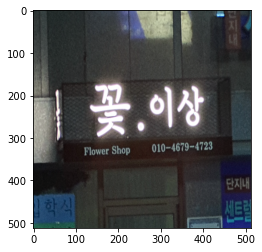

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


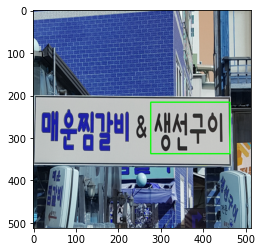

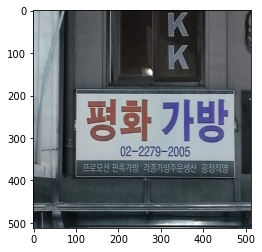

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


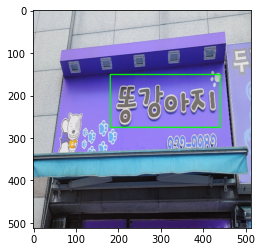

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


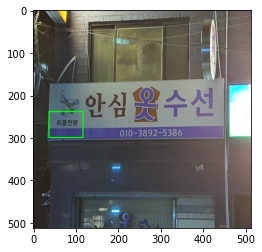

In [29]:
rand = np.random.randint(0,X_val.shape[0], size = 5)

for i in rand:
    
    predict_func(model , X_val[i:i+1] , 0.5, i)
    

In [1]:
# 결과 저장 및 비교 해야하는 결과 이미지들
# only test
# test dir

for i in os.listdir('Test/'):
    if i == '.DS_Store':
        continue
    else:
        img = cv2.imread(os.path.join('Test', i))
        
        try:
            img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)   
        except:
            break
            
        img = (img - 127.5) / 127.5
        predict_func(model, np.expand_dims(img, axis = 0), 0.5, i)

NameError: name 'os' is not defined

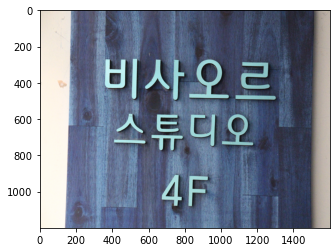

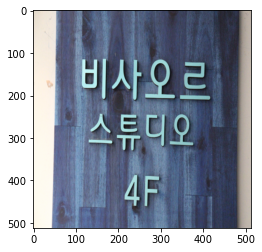

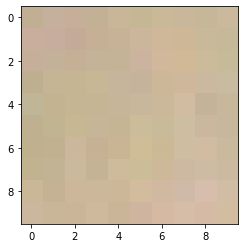

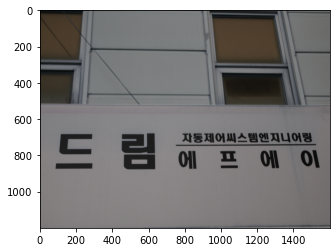

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


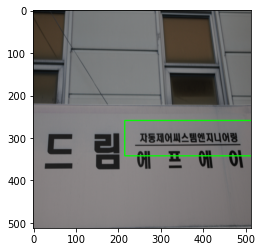

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [215.37831420898436, 259.9228677749634, 517.5731094360351, 342.86598110198975]


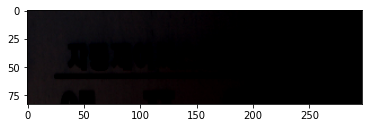

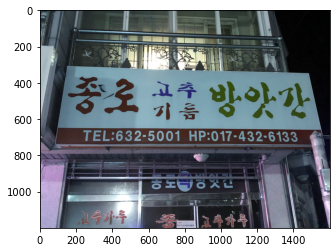

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


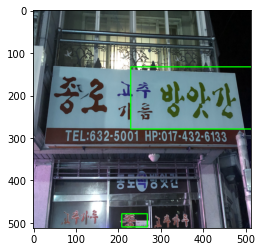

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [229.01166610717772, 133.80705280303954, 515.0424720764161, 279.55751209259034]


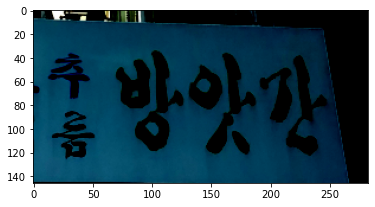

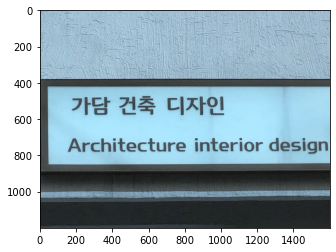

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


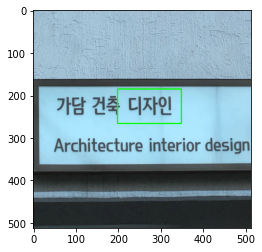

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [198.7276527404785, 185.17163276672363, 348.54299240112306, 266.8956985473633]


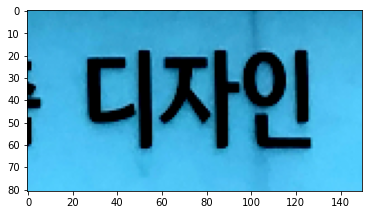

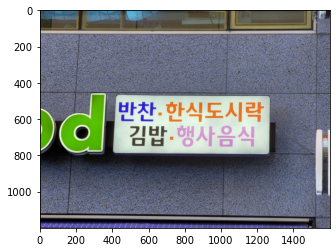

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


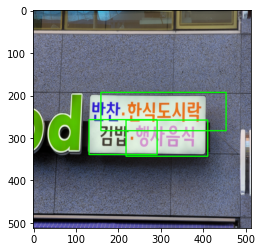

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [159.69289627075196, 193.2906509399414, 453.1289573669434, 283.7695182800293]


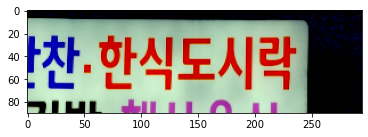

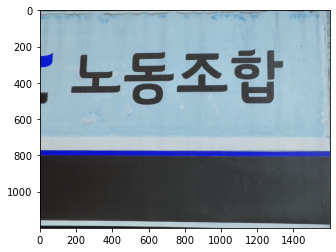

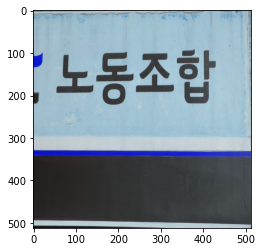

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


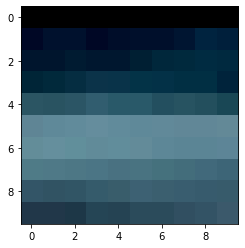

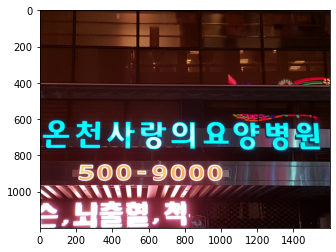

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


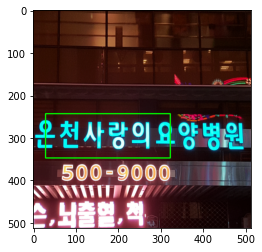

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [29.60515460968017, 243.59804763793946, 322.18471851348875, 347.7715469360352]


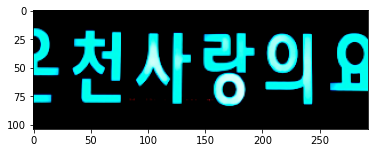

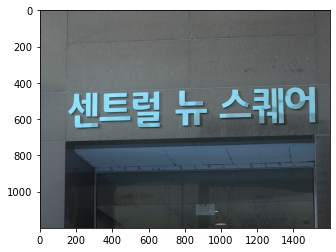

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


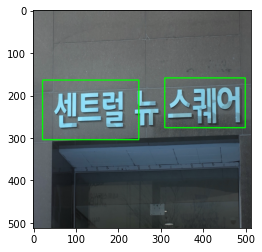

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [22.45429878234863, 164.51121349334716, 248.9456760406494, 304.2481611251831]


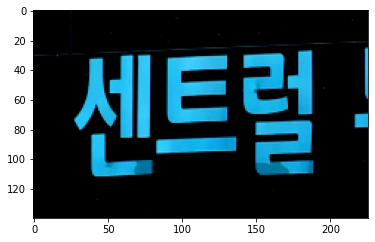

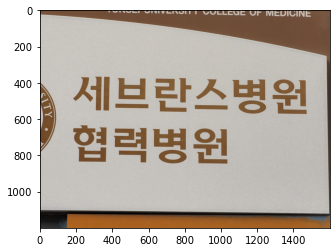

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


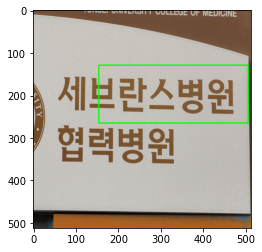

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [154.64925422668458, 129.32945585250854, 505.79433784484866, 265.4124445915222]


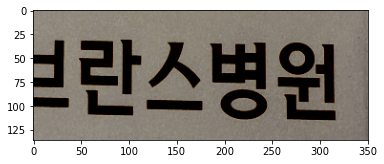

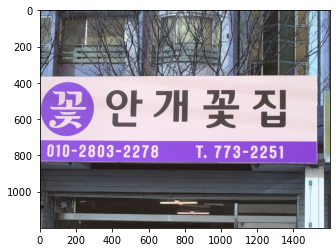

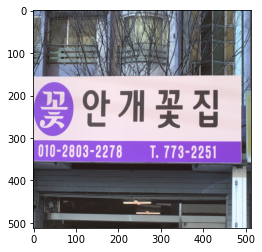

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


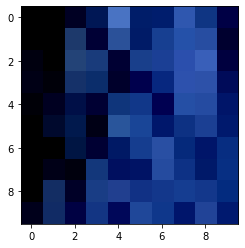

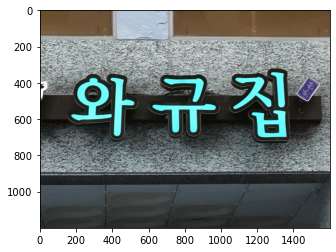

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


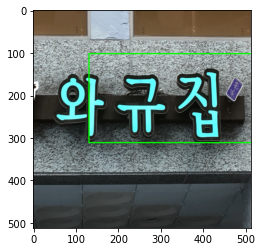

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [131.90113773345948, 102.5037742614746, 524.5769525527954, 311.08777847290037]


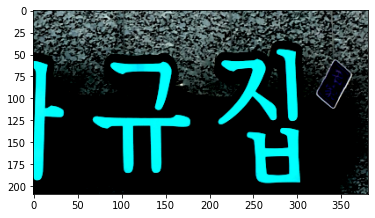

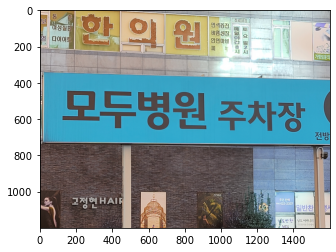

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


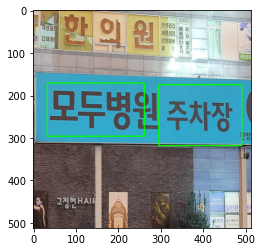

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [33.30502014160156, 171.9131534576416, 261.77875061035155, 296.82725257873534]


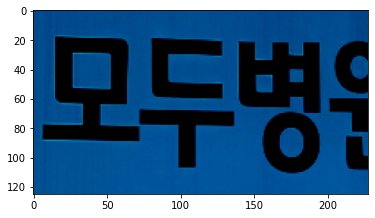

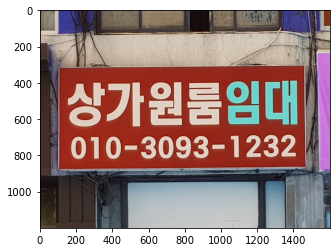

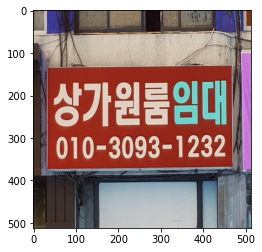

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


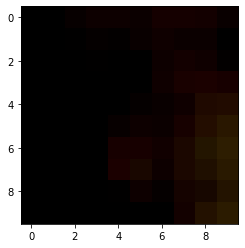

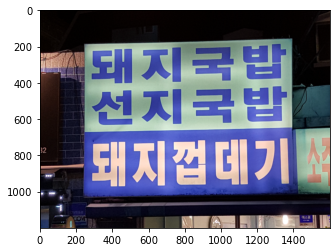

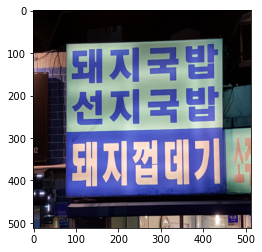

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


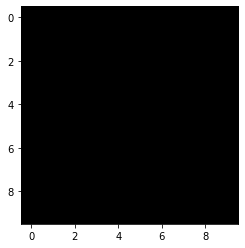

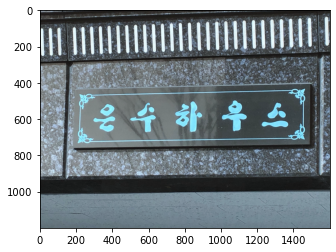

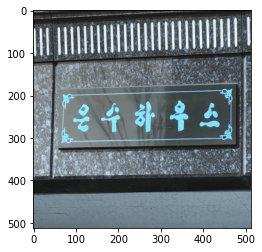

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


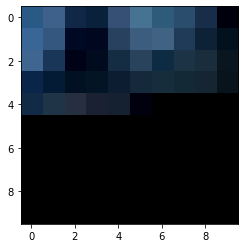

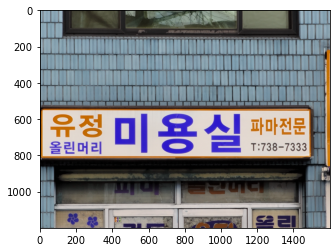

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


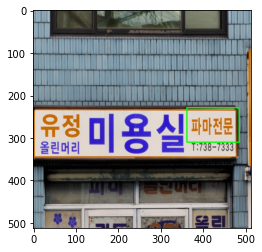

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [361.0351566314697, 229.28907508850097, 484.7018619537354, 310.8735569000244]


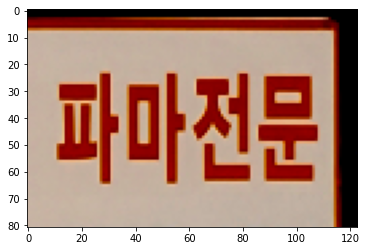

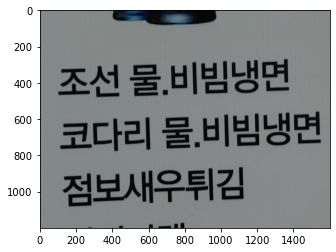

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


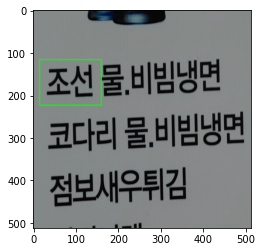

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [15.777599716186515, 116.46368141174315, 160.65068397521975, 223.00585823059083]


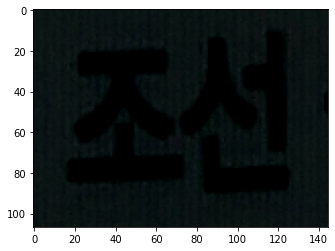

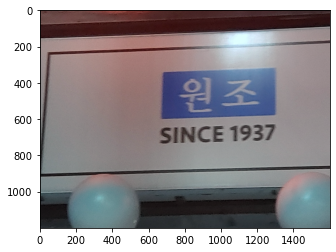

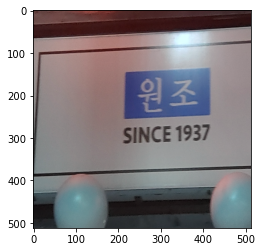

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


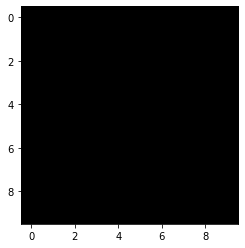

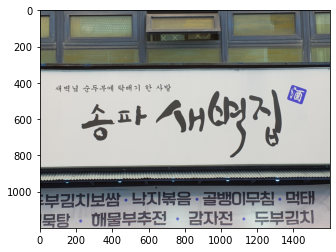

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


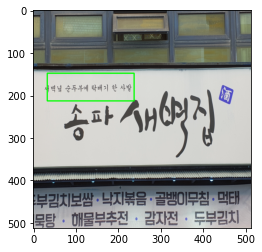

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [33.35720558166504, 148.00712757110597, 237.0233829498291, 213.29072399139403]


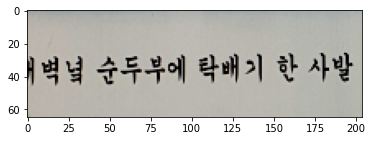

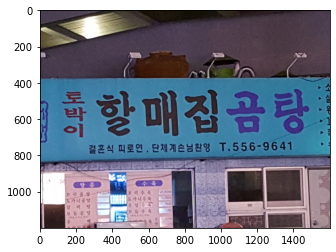

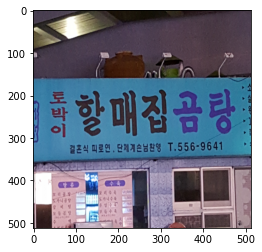

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


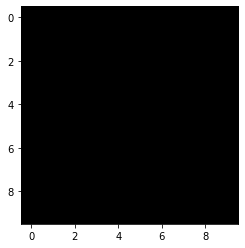

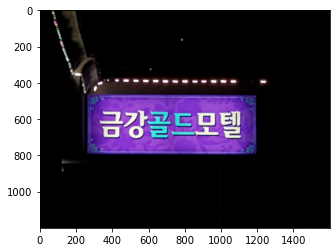

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


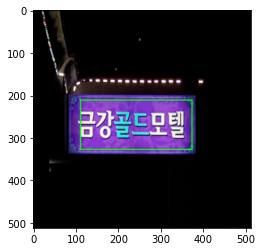

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [111.69541854858397, 211.36804141998292, 373.77451400756837, 327.76945743560793]


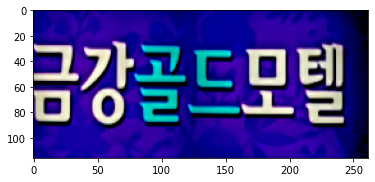

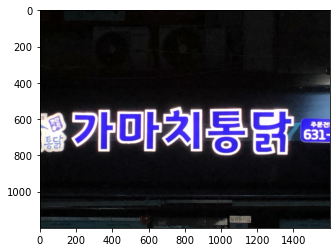

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


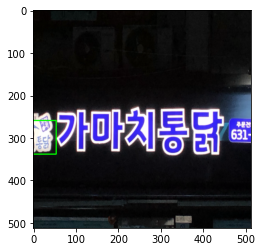

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coor ==> [-7.497561454772949, 259.78904209136965, 54.57366466522217, 338.5744356155395]


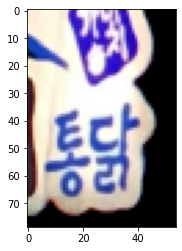

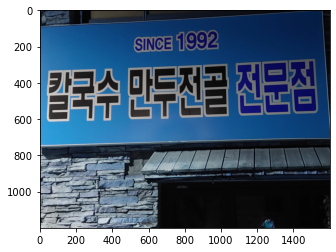

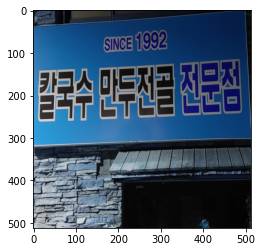

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


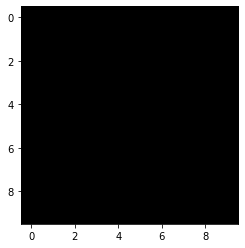

In [15]:
for i in os.listdir('Test/'):

    path = 'Test/'+i
    img = cv2.imread(os.path.join(path), cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.show()
    
    try:
        img = cv2.resize(img, (512,512), interpolation=cv2.INTER_AREA)
    except:
        break
    img = (img - 127.5)/127.5
    
    boxes = predict_func(model , np.expand_dims(img,axis= 0) , 0.5 , 'sample')

    if len(boxes) == 0:
            biggest_string = img[0:10, 0:10]
    else:
        coor = get_biggest_box_coordinate(boxes)
        print(f"coor ==> {coor}")
        biggest_string = get_biggest_box_image(img, coor)

    plt.imshow(biggest_string)
    plt.show()

    cv2.imwrite(os.path.join('ppt/' , i + '.jpg') , biggest_string*255.0)


    
    
    

### THE END